In [1]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 4291, done.
remote: Counting objects: 100% (569/569), done.
remote: Compressing objects: 100% (473/473), done.
remote: Total 4291 (delta 209), reused 405 (delta 93), pack-reused 3722
Receiving objects: 100% (4291/4291), 973.22 MiB | 18.94 MiB/s, done.
Resolving deltas: 100% (794/794), done.
Checking out files: 100% (2955/2955), done.
/content/STAT3007_Project


In [2]:
pip install colorednoise

  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp37-none-any.whl size=3983 sha256=ea1ed53d4b5954e7c1dddef2adb2320b9cbaf9c658d8193d9b5fd754cc9a94cd
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


In [3]:
import librosa
from librosa import display
import colorednoise as cn
import torch
import numpy as np
from IPython.display import Audio
import glob
from pre_process import *
from data_loading import *
import os
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor

import scipy
from torchsummary import summary

configure the device

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device == torch.device('cuda'))

True


# load the spectrogram data

In [5]:
train_noisy_spectrogram = np.load('/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/train_test_split_1185/noisy_6.npy')
train_clean_spectrogram = np.load('/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/train_test_split_1185/clean_6.npy')
test_noisy_spectrogram = np.load('/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/train_test_split_1185/noisy_4.npy')
test_clean_spectrogram = np.load('/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/train_test_split_1185/clean_4.npy')
test_noisy_target = np.load('/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/train_test_split_1185/targets_4.npy')

In [6]:
train_noisy_spectrogram = train_noisy_spectrogram.reshape(train_noisy_spectrogram.shape[0],1,train_noisy_spectrogram.shape[1],train_noisy_spectrogram.shape[2])
train_clean_spectrogram = train_clean_spectrogram.reshape(train_clean_spectrogram.shape[0],1,train_clean_spectrogram.shape[1],train_clean_spectrogram.shape[2])
test_noisy_spectrogram = test_noisy_spectrogram.reshape(test_noisy_spectrogram.shape[0],1,test_noisy_spectrogram.shape[1],test_noisy_spectrogram.shape[2])
test_clean_spectrogram = test_clean_spectrogram.reshape(test_clean_spectrogram.shape[0],1,test_clean_spectrogram.shape[1],test_clean_spectrogram.shape[2])


In [7]:
print(train_noisy_spectrogram.shape)
print(train_clean_spectrogram.shape)
print(test_noisy_spectrogram.shape)
print(test_clean_spectrogram.shape)

(711, 1, 128, 63)
(711, 1, 128, 63)
(474, 1, 128, 63)
(474, 1, 128, 63)


In [8]:
denoise_train = DatasetWrapper(torch.tensor(train_noisy_spectrogram), torch.tensor(train_clean_spectrogram))
denoise_test = DatasetWrapper(torch.tensor(test_noisy_spectrogram), torch.tensor(test_clean_spectrogram))

# Network Architecture

In [9]:
# Autoencoder with optimal hyper-parameters already put in
class Encoder(nn.Module):
  def __init__(self, filters = 8, kernal_size = (3,4)):
    super(Encoder, self).__init__()
    (K, S) = (5, 1)
    self.conv = nn.Sequential(nn.Conv2d(1, filters, kernel_size= kernal_size, stride = 1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.ReLU(),
                              nn.Conv2d(filters,filters,kernel_size= kernal_size, stride = 1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.Conv2d(filters,filters,kernel_size= kernal_size, stride = 1),
                              nn.ReLU()
                              )
    
  def forward(self, x):
    x = self.conv(x)
    return x


class Decoder(nn.Module):
  def __init__(self, filters = 8, kernal_size = (3,4), upsample_size1=(61,27), upsample_size2=(126,60)):
    super(Decoder, self).__init__()
    (K, S) = (2, 1)
    self.conv = nn.Sequential(nn.ConvTranspose2d(filters,filters, kernel_size = kernal_size),
                              nn.ReLU(),
                              nn.Upsample(size = upsample_size1),
                              nn.ConvTranspose2d(filters,filters, kernel_size = kernal_size),
                              nn.ReLU(),
                              nn.Upsample(size = upsample_size2),
                              nn.ConvTranspose2d(filters,1, kernel_size = kernal_size),
                              )
    
  def forward(self, x):
    x = self.conv(x)
    return x

class Autoencoder(nn.Module):
  def __init__(self, filters, kernal_size=(3,4), upsample_size1=(61,27), upsample_size2=(126,60)):
    super(Autoencoder,self).__init__()
    self.filters = filters
    self.kernal_size = kernal_size
    self.upsample_size1 = upsample_size1
    self.upsample_size2 = upsample_size2
    self.encoder = Encoder(filters, kernal_size)
    self.decoder = Decoder(filters, kernal_size, upsample_size1, upsample_size2)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [10]:
test_encoder = Encoder()
test_decoder = Decoder()
# if cuda gps available: 
if device == torch.device('cuda'):
    test_ae = Autoencoder(8).cuda()
else:
    test_ae = Autoencoder(8)
summary(test_ae,(1,128,63))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 126, 60]             104
              ReLU-2           [-1, 8, 126, 60]               0
         MaxPool2d-3            [-1, 8, 63, 30]               0
              ReLU-4            [-1, 8, 63, 30]               0
            Conv2d-5            [-1, 8, 61, 27]             776
              ReLU-6            [-1, 8, 61, 27]               0
         MaxPool2d-7            [-1, 8, 30, 13]               0
            Conv2d-8            [-1, 8, 28, 10]             776
              ReLU-9            [-1, 8, 28, 10]               0
          Encoder-10            [-1, 8, 28, 10]               0
  ConvTranspose2d-11            [-1, 8, 30, 13]             776
             ReLU-12            [-1, 8, 30, 13]               0
         Upsample-13            [-1, 8, 61, 27]               0
  ConvTranspose2d-14            [-1, 8,

In [11]:

def train_model(data, net, loss, nepoch , optim_name='Adam' ,lr = 0.01, batch_size = -1, use_cuda = False, print_output = True, test_data=None):
  
  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    # print()
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  if optim_name == 'Adam':
    optimizer = optim.Adam(net.parameters(), lr = lr)
  if optim_name == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr = lr)
  if optim_name == 'Adagrad':
    optimizer = optim.Adagrad(net.parameters(), lr = lr)
  if optim_name == 'RMSprop':
    optimizer = optim.RMSprop(net.parameters(), lr = lr)
  else:
    optimizer = optim.Adam(net.parameters(), lr = lr)
  # print(type(data))
  data = data.change_type(dtype)
  test_data = test_data.change_type(dtype)

  # test data
  if test_data != None:
      X_test, y_test = test_data.get_data()
    #   X_test = X_test.to('cpu')
    #   y_test = y_test.to('cpu')
      # print(type(X_test))
      test_losses = []

  if batch_size == -1:
    data_loader = DataLoader(data,
                         batch_size = data.dataset__len__, shuffle = True)
  
  else:
    data_loader = DataLoader(data,
                             batch_size = batch_size, shuffle = True)

  train_losses = []

  for epoch in range(nepoch):
     batch_losses = []
     for X_batch, y_batch in data_loader:
      # y_batch = y_batch.reshape(y_batch.shape[0],1,y_batch.shape[1],y_batch.shape[2])
      if use_cuda and device != None:
        # net = net.to(device)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

      optimizer.zero_grad()

      # since all our values are negative, we convert them to positive
      
      # print(next(net.parameters()).is_cuda)
      # print(id(net))
      pred = net(X_batch)

      Rn = loss(pred, y_batch)
      Rn.backward()
      optimizer.step()
      batch_losses.append(Rn.item())
     avg_loss = np.mean(np.array(batch_losses))
     train_losses.append(avg_loss)

     if test_data != None:
         # net_test = net.to(torch.device('cpu'))
         # net_test = net
         # print(id(net_test))
         test_pred = net(X_test)
         test_error = loss(test_pred, y_test)
         test_losses.append(test_error.item())

     if print_output:
      print('epoch:', epoch)
      print('loss:', avg_loss)
      print('------------')
     
    
  print('final loss:', Rn.item())

  if test_data != None:
    return net, train_losses, test_losses
  else:
    return net, train_losses, None

# Hyper-parameter turning

the number of filters

In [12]:
#@title Hyper-parameter turning - number of filters
loss = nn.MSELoss()
nepoch = 50
batch_size = 30
lr = 0.007
num_of_filter = {}
num_of_filter['nepoch'] = 50
num_of_filter['batch_size'] = 30
num_of_filter['lr'] = 0.007

filter_list = [8,14,16]
torch.manual_seed(69)

train_loss_log = []
test_loss_log = []

# filter number 8
AE = Autoencoder(8, (4,2), (59,30),(125,62))
_, train_losses, test_losses = train_model(denoise_train, AE, loss, nepoch=50, 
                                            lr=0.007, batch_size=30, use_cuda=False,
                                            print_output=False, test_data=denoise_test)
num_of_filter[8] = (train_losses, test_losses)


# filter number 14
AE2 = Autoencoder(14, (4,2), (59,30),(125,62))
_, train_losses2, test_losses2 = train_model(denoise_train, AE2, loss, nepoch=50, 
                                            lr=0.007, batch_size=30, use_cuda=False,
                                            print_output=False, test_data=denoise_test)
num_of_filter[14] = (train_losses2, test_losses2)

# filter number 16
AE3 = Autoencoder(16, (4,2), (59,30),(125,62))
_, train_losses3, test_losses3 = train_model(denoise_train, AE3, loss, nepoch=50, 
                                            lr=0.007, batch_size=30, use_cuda=False,
                                            print_output=False, test_data=denoise_test)
num_of_filter[16] = (train_losses3, test_losses3)

final loss: 74.38644409179688
final loss: 85.3998031616211
final loss: 101.150390625


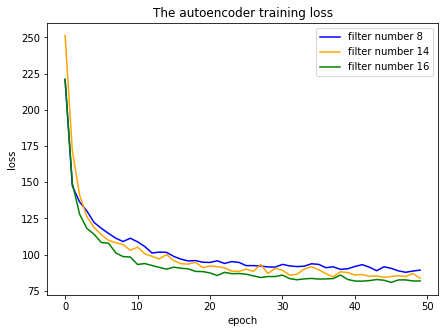

In [14]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(num_of_filter[8][0])), num_of_filter[8][0], color='blue', label='filter number 8')
plt.plot(np.arange(len(num_of_filter[14][0])), num_of_filter[14][0], color='orange', label='filter number 14')
plt.plot(np.arange(len(num_of_filter[16][0])), num_of_filter[16][0], color='green', label='filter number 16')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('The autoencoder training loss')
plt.show()


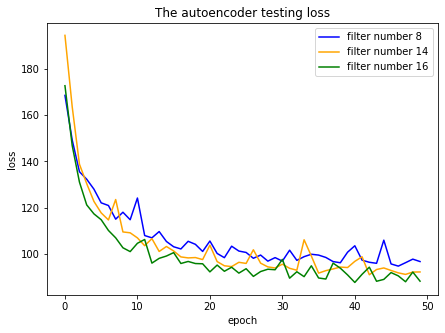

In [15]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(num_of_filter[8][0])), num_of_filter[8][1], color='blue', label='filter number 8')
plt.plot(np.arange(len(num_of_filter[14][0])), num_of_filter[14][1], color='orange', label='filter number 14')
plt.plot(np.arange(len(num_of_filter[16][0])), num_of_filter[16][1], color='green', label='filter number 16')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('The autoencoder testing loss')
plt.show()

test with kernel size

In [1]:

loss = nn.MSELoss()
nepoch = 20
batch_size = 30
lr = 0.01
kernal_sizes = {}
kernal_sizes['nepoch'] = 20
kernal_sizes['batch_size'] = 30
kernal_sizes['lr'] = 0.01
kernal_sizes['num_of_filter'] = 8
kernal_size_list = [[(1,2),(64,30),(128,62)], [(1,3),(64,28),(128,61)], [(1,4),(64,27),(128,60)], 
                    [(2,1),(62,31),(127,63)], [(2,2),(62,30),(127,62)], [(2,3),(62,28),(127,61)], [(2,4),(62,27),(127,60)],
                    [(3,1),(61,31),(126,63)], [(3,2),(61,30),(126,62)], [(3,3),(61,28),(126,61)], [(3,4),(61,27),(126,60)],
                    [(4,1),(59,31),(125,63)], [(4,2),(59,30),(125,62)], [(4,3),(59,28),(125,61)], [(4,4),(59,27),(125,60)]]

torch.manual_seed(69)
for kernal_size in kernal_size_list:
    AE = Autoencoder(8, kernal_size[0], kernal_size[1], kernal_size[2])
    _, train_loss_log, test_loss_log = train_model(denoise_train,AE, loss, nepoch = nepoch,lr = 0.01, batch_size = batch_size, use_cuda = True,print_output = False)
    kernal_sizes[kernal_size[0]] = (train_loss_log, test_loss_log)


NameError: name 'nn' is not defined

In [17]:
kernal_size_train_loss = []
for kernal_size in kernal_size_list:
    train_loss_log = kernal_sizes[kernal_size[0]][0]
    kernal_size_train_loss.append(train_loss_log[-1].item())

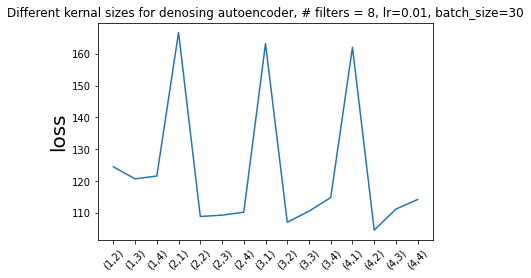

In [19]:
fig, ax = plt.subplots()
ax.plot(np.arange(1,16), kernal_size_train_loss)
ax.set_xticks(np.arange(1,16))
ax.set_xticklabels(['(1,2)','(1,3)','(1,4)','(2,1)','(2,2)','(2,3)','(2,4)','(3,1)',
                    '(3,2)','(3,3)','(3,4)','(4,1)','(4,2)','(4,3)','(4,4)'])
plt.xticks(rotation = 45)
plt.ylabel('loss', size=20)
plt.title('Different kernal sizes for denosing autoencoder, # filters = 8, lr=0.01, batch_size=30')
plt.show()

Test optimizer and learning rate

In [14]:
loss = nn.MSELoss()
lr_list = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
AE2 = Autoencoder(8, (4,2), (59,30),(125,62))
epoch_list = [10, 20, 30, 40, 50]


adam_epoch_and_learning_rate = []
SGD_epoch_and_learning_rate = []
RMSProp_epoch_and_learning_rate = []
Adagrad_epoch_and_learning_rate = []

In [15]:
# Adam
for lr in lr_list:
    for epoch in epoch_list:
        AE = Autoencoder(8, (4,2), (59,30),(125,62))
        _, train_loss_log, test_loss_log = train_model(denoise_train,AE, loss, nepoch = epoch,lr = lr, batch_size = 30, test_data=denoise_test, use_cuda = True,print_output = False)
        adam_epoch_and_learning_rate.append((lr, epoch, test_loss_log[-1]))

# net, train_loss_log, test_loss_log = train_model(denoise_train,AE2, loss, nepoch = 20,lr = 0.01, batch_size = 30, use_cuda = True,print_output = True, test_data=denoise_test)


final loss: 132.58958435058594
final loss: 114.55496978759766
final loss: 113.90611267089844
final loss: 102.3037109375
final loss: 114.25006866455078
final loss: 124.57814025878906
final loss: 109.8772964477539
final loss: 103.22974395751953
final loss: 100.0066146850586
final loss: 94.70124816894531
final loss: 137.3030242919922
final loss: 91.22372436523438
final loss: 79.03907775878906
final loss: 108.4793930053711
final loss: 86.63829040527344
final loss: 109.7714614868164
final loss: 97.27883911132812
final loss: 92.5533676147461
final loss: 89.76303100585938
final loss: 118.6918716430664
final loss: 111.16532135009766
final loss: 98.70982360839844
final loss: 102.26840209960938
final loss: 74.58870697021484
final loss: 126.74288177490234
final loss: 101.65137481689453
final loss: 133.64422607421875
final loss: 92.15044403076172
final loss: 78.1949691772461
final loss: 80.29229736328125
final loss: 119.39094543457031
final loss: 106.39591979980469
final loss: 98.42961120605469
fi

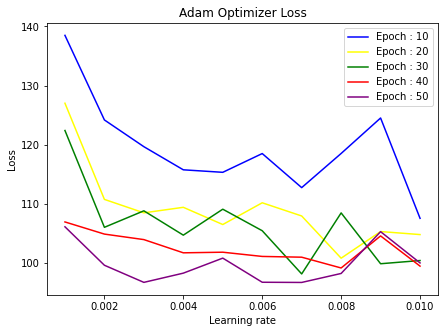

In [16]:
adam_epoch_10 = []
adam_epoch_20 = []
adam_epoch_30 = []
adam_epoch_40 = []
adam_epoch_50 = []

for item in adam_epoch_and_learning_rate:
    if item[1] == 10:
        adam_epoch_10.append([item[0], item[2]])
    if item[1] == 20:
        adam_epoch_20.append([item[0], item[2]])
    if item[1] == 30:
        adam_epoch_30.append([item[0], item[2]])
    if item[1] == 40:
        adam_epoch_40.append([item[0], item[2]])
    if item[1] == 50:
        adam_epoch_50.append([item[0], item[2]])

adam_epoch_10 = np.asarray(adam_epoch_10)
adam_epoch_20 = np.asarray(adam_epoch_20)
adam_epoch_30 = np.asarray(adam_epoch_30)
adam_epoch_40 = np.asarray(adam_epoch_40)
adam_epoch_50 = np.asarray(adam_epoch_50)


plt.figure(figsize=(7,5))
plt.plot(adam_epoch_10[:,0], adam_epoch_10[:,1], color='blue', label='Epoch : 10')
plt.plot(adam_epoch_20[:,0], adam_epoch_20[:,1], color='yellow', label='Epoch : 20')
plt.plot(adam_epoch_30[:,0], adam_epoch_30[:,1], color='green', label='Epoch : 30')
plt.plot(adam_epoch_40[:,0], adam_epoch_40[:,1], color='red', label='Epoch : 40')
plt.plot(adam_epoch_50[:,0], adam_epoch_50[:,1], color='purple', label='Epoch : 50')
plt.legend()
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('Adam Optimizer Loss')
plt.show()

In [18]:
# SGD
for lr in lr_list:
    for epoch in epoch_list:
        AE2 = Autoencoder(8, (4,2), (59,30),(125,62))
        _, train_loss_log, test_loss_log = train_model(denoise_train,AE2, loss, nepoch = epoch,lr = lr, batch_size = 30, optim_name='SGD',test_data=denoise_test, use_cuda = True,print_output = False,)
        SGD_epoch_and_learning_rate.append((lr, epoch, test_loss_log[-1]))
        
# net, train_loss_log, test_loss_log = train_model(denoise_train,AE2, loss, nepoch = 20,lr = 0.01, batch_size = 30, use_cuda = True,print_output = True, test_data=denoise_test)


final loss: 140.21005249023438
final loss: 148.09783935546875
final loss: 112.35894012451172
final loss: 104.79045104980469
final loss: 104.4011459350586
final loss: 120.3328628540039
final loss: 109.19403076171875
final loss: 98.5577163696289
final loss: 99.2020492553711
final loss: 117.08091735839844
final loss: 106.573486328125
final loss: 101.67963409423828
final loss: 84.47056579589844
final loss: 83.50756072998047
final loss: 75.25281524658203
final loss: 94.320068359375
final loss: 120.88681030273438
final loss: 97.43111419677734
final loss: 84.4829330444336
final loss: 109.19640350341797
final loss: 108.9732894897461
final loss: 90.01986694335938
final loss: 84.70439147949219
final loss: 105.19084167480469
final loss: 91.32767486572266
final loss: 93.56364440917969
final loss: 108.62541198730469
final loss: 83.69922637939453
final loss: 83.46797180175781
final loss: 90.32221221923828
final loss: 107.85803985595703
final loss: 110.45879364013672
final loss: 118.59422302246094
fi

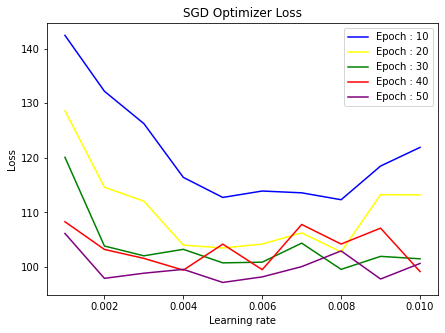

In [19]:
SGD_epoch_10 = []
SGD_epoch_20 = []
SGD_epoch_30 = []
SGD_epoch_40 = []
SGD_epoch_50 = []

for item in SGD_epoch_and_learning_rate:
    if item[1] == 10:
       SGD_epoch_10.append([item[0], item[2]])
    if item[1] == 20:
       SGD_epoch_20.append([item[0], item[2]])
    if item[1] == 30:
       SGD_epoch_30.append([item[0], item[2]])
    if item[1] == 40:
       SGD_epoch_40.append([item[0], item[2]])
    if item[1] == 50:
       SGD_epoch_50.append([item[0], item[2]])

SGD_epoch_10 = np.asarray(SGD_epoch_10)
SGD_epoch_20 = np.asarray(SGD_epoch_20)
SGD_epoch_30 = np.asarray(SGD_epoch_30)
SGD_epoch_40 = np.asarray(SGD_epoch_40)
SGD_epoch_50 = np.asarray(SGD_epoch_50)


plt.figure(figsize=(7,5))
plt.plot(SGD_epoch_10[:,0], SGD_epoch_10[:,1], color='blue', label='Epoch : 10')
plt.plot(SGD_epoch_20[:,0], SGD_epoch_20[:,1], color='yellow', label='Epoch : 20')
plt.plot(SGD_epoch_30[:,0], SGD_epoch_30[:,1], color='green', label='Epoch : 30')
plt.plot(SGD_epoch_40[:,0], SGD_epoch_40[:,1], color='red', label='Epoch : 40')
plt.plot(SGD_epoch_50[:,0], SGD_epoch_50[:,1], color='purple', label='Epoch : 50')
plt.legend()
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('SGD Optimizer Loss')
plt.show()

In [22]:
# RMSProp
for lr in lr_list:
    for epoch in epoch_list:
        AE3 = Autoencoder(8, (4,2), (59,30),(125,62))
        _, train_loss_log, test_loss_log = train_model(denoise_train,AE3, loss, nepoch = epoch,lr = lr, batch_size = 30, test_data=denoise_test, optim_name='RMSProp', use_cuda = True,print_output = False)
        RMSProp_epoch_and_learning_rate.append((lr, epoch, test_loss_log[-1]))

# net, train_loss_log, test_loss_log = train_model(denoise_train,AE2, loss, nepoch = 20,lr = 0.01, batch_size = 30, use_cuda = True,print_output = True, test_data=denoise_test)


final loss: 128.57626342773438
final loss: 118.56702423095703
final loss: 104.97456359863281
final loss: 89.1996841430664
final loss: 87.00691223144531
final loss: 140.3135986328125
final loss: 120.56057739257812
final loss: 80.56855773925781
final loss: 69.60016632080078
final loss: 101.22208404541016
final loss: 101.9007339477539
final loss: 75.8796157836914
final loss: 105.11458587646484
final loss: 92.99593353271484
final loss: 79.63784790039062
final loss: 122.53960418701172
final loss: 100.51859283447266
final loss: 77.58541107177734
final loss: 88.86266326904297
final loss: 87.35343170166016
final loss: 95.24333190917969
final loss: 95.04776000976562
final loss: 82.07386779785156
final loss: 93.36859893798828
final loss: 118.12946319580078
final loss: 98.99711608886719
final loss: 108.59225463867188
final loss: 94.37025451660156
final loss: 125.48588562011719
final loss: 108.6141586303711
final loss: 95.26631927490234
final loss: 93.27787780761719
final loss: 93.15399169921875
f

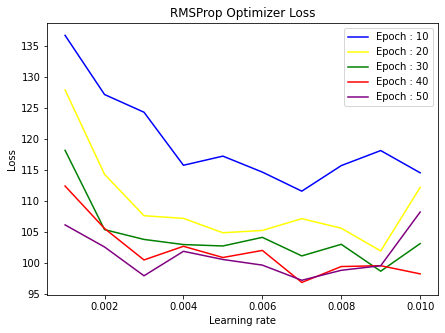

In [23]:
RMSProp_epoch_10 = []
RMSProp_epoch_20 = []
RMSProp_epoch_30 = []
RMSProp_epoch_40 = []
RMSProp_epoch_50 = []

for item in RMSProp_epoch_and_learning_rate:
    if item[1] == 10:
        RMSProp_epoch_10.append([item[0], item[2]])
    if item[1] == 20:
        RMSProp_epoch_20.append([item[0], item[2]])
    if item[1] == 30:
        RMSProp_epoch_30.append([item[0], item[2]])
    if item[1] == 40:
        RMSProp_epoch_40.append([item[0], item[2]])
    if item[1] == 50:
        RMSProp_epoch_50.append([item[0], item[2]])

RMSProp_epoch_10 = np.asarray(RMSProp_epoch_10)
RMSProp_epoch_20 = np.asarray(RMSProp_epoch_20)
RMSProp_epoch_30 = np.asarray(RMSProp_epoch_30)
RMSProp_epoch_40 = np.asarray(RMSProp_epoch_40)
RMSProp_epoch_50 = np.asarray(RMSProp_epoch_50)


plt.figure(figsize=(7,5))
plt.plot(RMSProp_epoch_10[:,0], RMSProp_epoch_10[:,1], color='blue', label='Epoch : 10')
plt.plot(RMSProp_epoch_20[:,0], RMSProp_epoch_20[:,1], color='yellow', label='Epoch : 20')
plt.plot(RMSProp_epoch_30[:,0], RMSProp_epoch_30[:,1], color='green', label='Epoch : 30')
plt.plot(RMSProp_epoch_40[:,0], RMSProp_epoch_40[:,1], color='red', label='Epoch : 40')
plt.plot(RMSProp_epoch_50[:,0], RMSProp_epoch_50[:,1], color='purple', label='Epoch : 50')
plt.legend()
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('RMSProp Optimizer Loss')
plt.show()

In [25]:
# Adagrad
for lr in lr_list:
    for epoch in epoch_list:
        AE4 = Autoencoder(8, (4,2), (59,30),(125,62))
        _, train_loss_log, test_loss_log = train_model(denoise_train,AE4, loss, nepoch = epoch,lr = lr, batch_size = 30, test_data=denoise_test, optim_name='Adagrad', use_cuda = True,print_output = False)
        Adagrad_epoch_and_learning_rate.append((lr, epoch, test_loss_log[-1]))

# net, train_loss_log, test_loss_log = train_model(denoise_train,AE2, loss, nepoch = 20,lr = 0.01, batch_size = 30, use_cuda = True,print_output = True, test_data=denoise_test)


final loss: 139.7972412109375
final loss: 114.6858139038086
final loss: 123.13819122314453
final loss: 108.9961166381836
final loss: 93.05548858642578
final loss: 109.45382690429688
final loss: 113.57807922363281
final loss: 118.98372650146484
final loss: 92.52240753173828
final loss: 120.81475830078125
final loss: 98.82815551757812
final loss: 80.92414093017578
final loss: 84.0448989868164
final loss: 95.64458465576172
final loss: 98.7125244140625
final loss: 111.77421569824219
final loss: 97.54916381835938
final loss: 111.595703125
final loss: 96.50796508789062
final loss: 111.78642272949219
final loss: 87.82028198242188
final loss: 99.822998046875
final loss: 86.30805206298828
final loss: 90.11742401123047
final loss: 83.4486312866211
final loss: 95.1518325805664
final loss: 99.46434783935547
final loss: 81.12073516845703
final loss: 117.71322631835938
final loss: 96.44173431396484
final loss: 95.69062042236328
final loss: 79.65924072265625
final loss: 103.361328125
final loss: 70.3

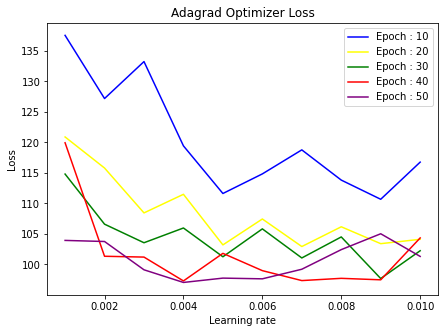

In [26]:
Adagrad_epoch_10 = []
Adagrad_epoch_20 = []
Adagrad_epoch_30 = []
Adagrad_epoch_40 = []
Adagrad_epoch_50 = []

for item in Adagrad_epoch_and_learning_rate:
    if item[1] == 10:
        Adagrad_epoch_10.append([item[0], item[2]])
    if item[1] == 20:
        Adagrad_epoch_20.append([item[0], item[2]])
    if item[1] == 30:
        Adagrad_epoch_30.append([item[0], item[2]])
    if item[1] == 40:
        Adagrad_epoch_40.append([item[0], item[2]])
    if item[1] == 50:
        Adagrad_epoch_50.append([item[0], item[2]])

Adagrad_epoch_10 = np.asarray(Adagrad_epoch_10)
Adagrad_epoch_20 = np.asarray(Adagrad_epoch_20)
Adagrad_epoch_30 = np.asarray(Adagrad_epoch_30)
Adagrad_epoch_40 = np.asarray(Adagrad_epoch_40)
Adagrad_epoch_50 = np.asarray(Adagrad_epoch_50)


plt.figure(figsize=(7,5))
plt.plot(Adagrad_epoch_10[:,0], Adagrad_epoch_10[:,1], color='blue', label='Epoch : 10')
plt.plot(Adagrad_epoch_20[:,0], Adagrad_epoch_20[:,1], color='yellow', label='Epoch : 20')
plt.plot(Adagrad_epoch_30[:,0], Adagrad_epoch_30[:,1], color='green', label='Epoch : 30')
plt.plot(Adagrad_epoch_40[:,0], Adagrad_epoch_40[:,1], color='red', label='Epoch : 40')
plt.plot(Adagrad_epoch_50[:,0], Adagrad_epoch_50[:,1], color='purple', label='Epoch : 50')
plt.legend()
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('Adagrad Optimizer Loss')
plt.show()

The model train with all the noisy data on the drive, 50 epochs, with another optimal hyper-parameters

# Run the finalised optimal model

In [12]:
loss = nn.MSELoss()
AE = Autoencoder(16, (4,2), (59,30),(125,62))
net, train_loss_log, test_loss_log = train_model(denoise_train,AE, loss, nepoch = 50,lr = 0.01, batch_size = 30, use_cuda = True,print_output = True, test_data=denoise_test)


epoch: 0
loss: 361.42577997843426
------------
epoch: 1
loss: 184.45187123616537
------------
epoch: 2
loss: 146.82619285583496
------------
epoch: 3
loss: 132.09785143534342
------------
epoch: 4
loss: 123.60812282562256
------------
epoch: 5
loss: 118.84848403930664
------------
epoch: 6
loss: 118.05768775939941
------------
epoch: 7
loss: 112.76523240407307
------------
epoch: 8
loss: 115.66715621948242
------------
epoch: 9
loss: 108.80764230092366
------------
epoch: 10
loss: 105.72014808654785
------------
epoch: 11
loss: 103.5319414138794
------------
epoch: 12
loss: 101.3897720972697
------------
epoch: 13
loss: 105.91181151072185
------------
epoch: 14
loss: 103.77679220835368
------------
epoch: 15
loss: 100.44718901316325
------------
epoch: 16
loss: 99.19005966186523
------------
epoch: 17
loss: 98.67330423990886
------------
epoch: 18
loss: 98.56618563334148
------------
epoch: 19
loss: 96.52067279815674
------------
epoch: 20
loss: 97.30068079630534
------------
epoch: 21

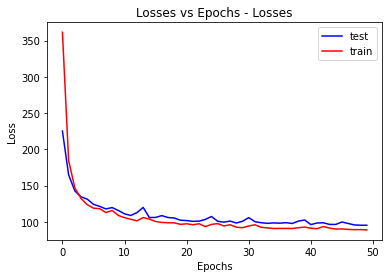

In [13]:
plt.plot(np.arange(len(test_loss_log)), test_loss_log, color='blue', label='test')
plt.plot(np.arange(len(train_loss_log)), train_loss_log, color='red', label='train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses vs Epochs - Losses')
plt.show()

# Save model parameters

In [16]:
state_save_path = '/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/denoised_saved_model_parameters'
torch.save(net.state_dict(), state_save_path)

In [17]:
model = Autoencoder(16, (4,2), (59,30),(125,62))
model.load_state_dict(torch.load(state_save_path))

<All keys matched successfully>

# Save model

In [14]:
state_save_path = '/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/denoised_saved_model'

In [18]:
torch.save(net, state_save_path)

In [16]:
the_model = torch.load(state_save_path)


<class '__main__.Autoencoder'>


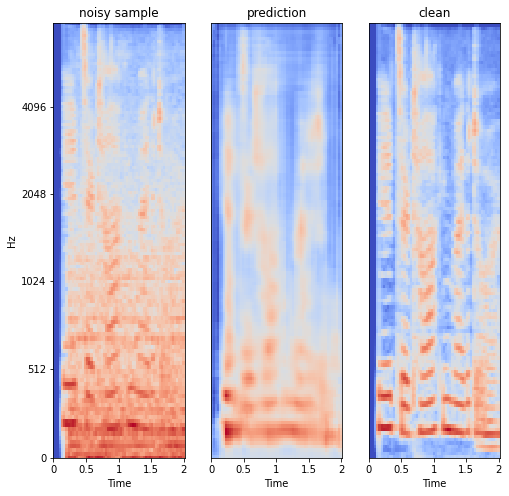

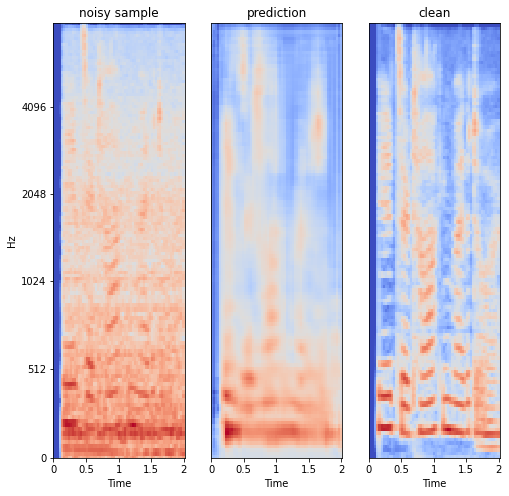

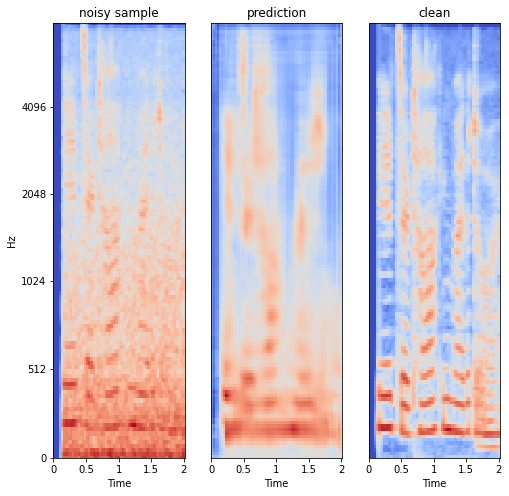

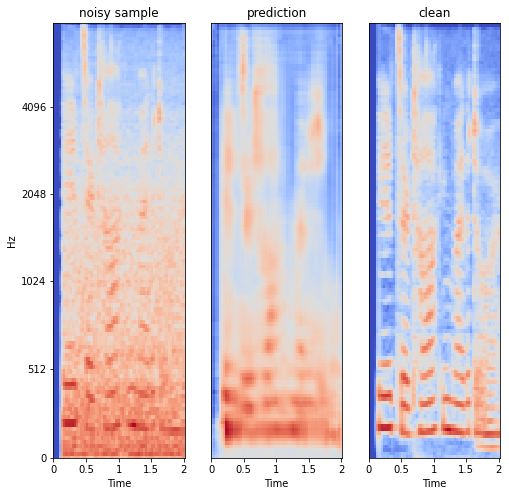

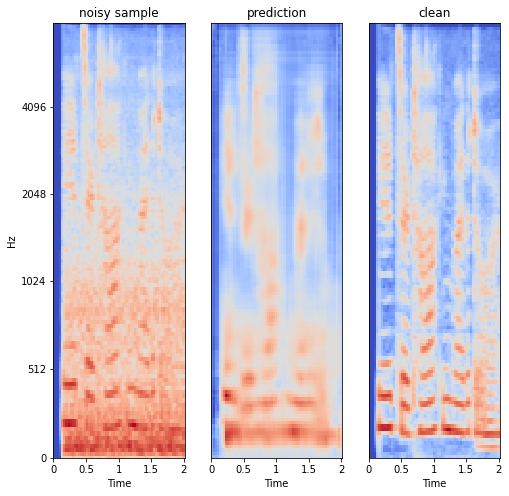

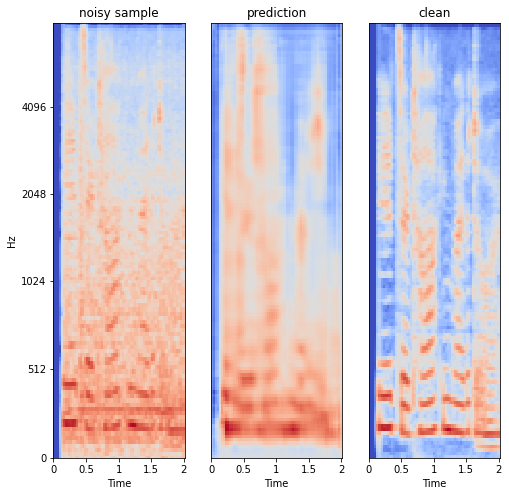

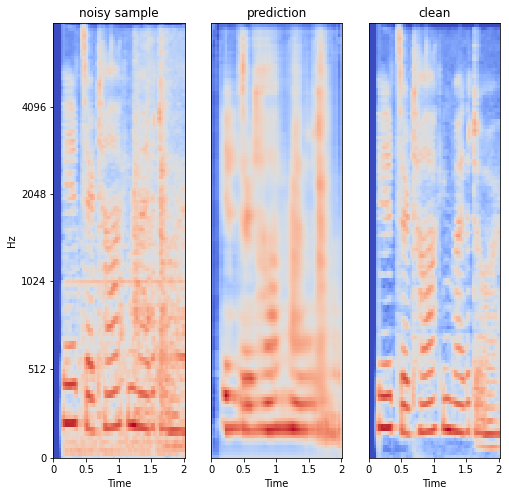

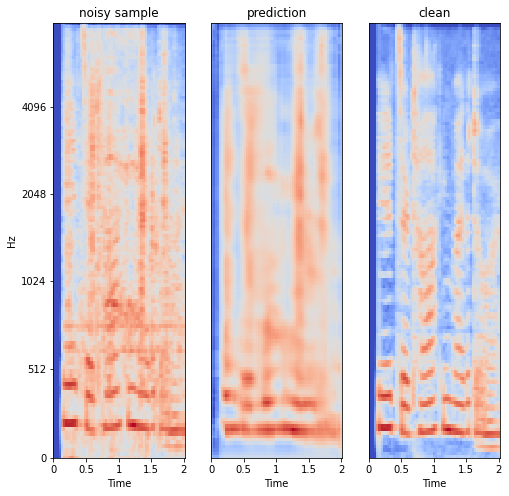

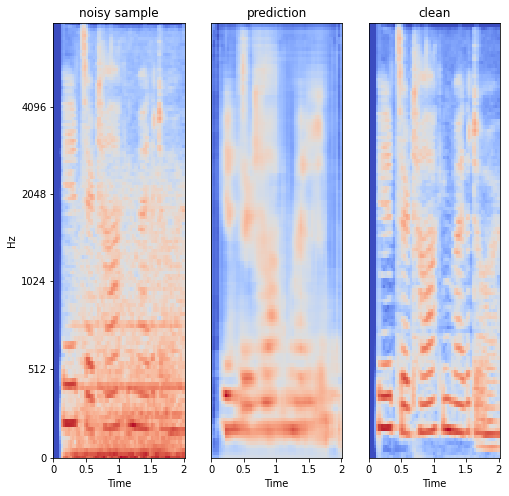

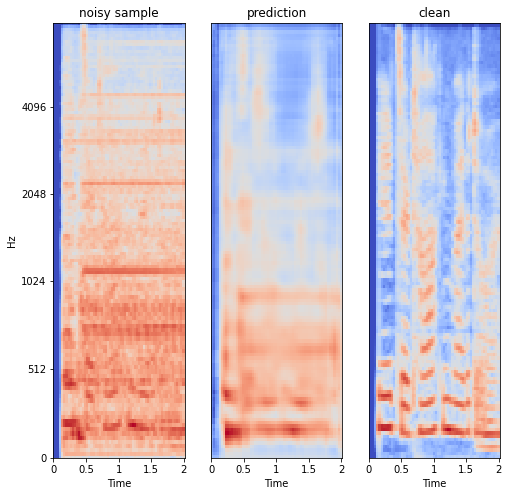

In [17]:
X_test, y_test = denoise_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
if (device == torch.device('cuda')):
    the_model = the_model.to(torch.device('cpu'))
print(type(the_model))
y_pred = the_model(X_test)

for i in range(10):
    plt.figure(figsize = (8,8))
    plt.subplot2grid((1,3),(0,0))
    librosa.display.specshow(X_test[i,0].detach().numpy(), y_axis='mel', fmax=8000, x_axis='time', sr =16000);
    plt.title('noisy sample')

    plt.subplot2grid((1,3),(0,1))
    librosa.display.specshow(y_pred[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('prediction')


    ax = plt.subplot2grid((1,3),(0,2))
    librosa.display.specshow(y_test[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('clean')
    plt.show()